### Imports

In [1]:
!pip install torchtext==0.6.0 --quiet
import torch
import inflect
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 10.3 MB/s 


device(type='cuda', index=0)

#Section 1 Data prep and research

I created a new Dataset class to handle the data. There are two components to the dataset that it returns: a word representation and numerical representation.

In [2]:
class numbersDataset(torch.utils.data.Dataset):
  def __init__(self, numbers = 100000):

    #Use inflect to turn numbers into strings
    p = inflect.engine()
    #Make temporary lists
    l_nums = []
    l_words = []
    #Declare SOS and EOS chars
    self.SOS = 1
    self.EOS = 2
    #FOr each num in the dataset
    for x in range(numbers):
      #Add the number+3. Adding three since EOS, SOS, and PAD are 0,1,2
      temp = [int(d)+3 for d in str(x)]
      #Add EOS and SOS chars
      temp.insert(0, self.SOS)
      temp.append(self.EOS)
      #Make the number and word lists
      l_nums.append(torch.tensor(temp))
      l_words.append(p.number_to_words(x))

    #Generate a vocab and number of words for the word representation
    self.vocab = dict([(y,x+3) for x,y in enumerate(sorted(set(" ".join(l_words))))])
    self.n_words = len(self.vocab) + 3

    #Make a list for processed word representation(Mapped to ints)
    processed_l_words = []
    for l in range(0, len(l_words)):
      #Start with SOS
      temp = [self.SOS]
      for x in range(len(l_words[l])):
        #Add the int mapping for each char in the word representation(From vocab)
        processed_text = [self.vocab[i] for i in l_words[l][x]][0]
        temp.append(processed_text)
      #Add EOS
      temp.append(self.EOS)
      processed_l_words.append(torch.from_numpy(np.array(temp)))

    #Save the two representations. THe numerical and word(processed so that it is now also numbers) representations
    self.nums = l_nums
    self.words = processed_l_words
  def __len__(self):
    return numbers
  def __getitem__(self, index):
    return  self.words[index], self.nums[index]

I also created a dictionary to translate the numerical representation back to the original numbers. This is necessary to remove PAD/EOS/SOS and undo the +3 in my dataset(The +3 comes from adding three new characters for PAD/EOS/SOS)

In [3]:
idx_2_word = {}
for x in range(3, 13):
  idx_2_word[x] = str(x-3)

idx_2_word[0] = '<pad>'
idx_2_word[1] = '<sos>'
idx_2_word[2] = '<eos>'

Since sequences in both "Languages" aren't the same length, create a collate function to bad both sequences

In [4]:
from torch.nn.utils.rnn import pad_sequence
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  outs = [x.shape[0] for x in xx]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy = pad_sequence(yy, batch_first=True, padding_value=0)
  return xx_pad.T, yy.T, outs

Create a dataset of 100000 numbers

In [5]:
numbers = 100000
dataset = numbersDataset(numbers)

Check the vocab and number of word characters

In [6]:
print(dataset.vocab)
dataset.n_words
#It looks as expected!

{' ': 3, ',': 4, '-': 5, 'a': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'l': 13, 'n': 14, 'o': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23, 'z': 24}


25

Declare a batch size and create dataloaders

In [7]:
batch_size = 1024
from torch.utils.data import DataLoader

#Declare lengths of train, test, valid sets
train_len = int(numbers * 0.6)
test_len = int(numbers * 0.2)
validation_len = len(dataset)-(train_len+test_len)


#Split the dataset
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, validation_len, test_len])

#Make dataloaders
train_DL = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
test_DL =DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_DL = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

Take a sample batch and look at it as a sanity check. Here, I make sure the shapes and lengths look correct

In [8]:
count = 0
for data in train_DL:
  if count ==0 :
    print("Shapes", data[0].shape, data[1].shape)
    print()
    print("Words representation - ", " Length - ", len(data[0]))
    print()
    print("Numbers representation", " Length - ", len(data[1]))
    temp_words = data[0]
    temp_num = data[1]
    count += 1
temp_words_idx = (temp_words).cpu().detach().numpy()
temp_num_idx = (temp_num).cpu().detach().numpy()

Shapes torch.Size([56, 1024]) torch.Size([7, 1024])

Words representation -   Length -  56

Numbers representation  Length -  7


Also look at the words representation to make sure it all worked as expected. Each sample should begin with 1(SOS), end with 2(EOS), and be padded with zeros(PAD)

In [9]:
df_words_idx = pd.DataFrame(data = temp_words_idx, columns = [str("S_")+str(x) for x in np.arange(1, batch_size+1)])
df_words_idx.index.name = 'Time Steps'
df_words_idx.index = df_words_idx.index + 1 

df_words_idx

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,S_11,S_12,S_13,S_14,S_15,S_16,S_17,S_18,S_19,S_20,S_21,S_22,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32,S_33,S_34,S_35,S_36,S_37,S_38,S_39,S_40,...,S_985,S_986,S_987,S_988,S_989,S_990,S_991,S_992,S_993,S_994,S_995,S_996,S_997,S_998,S_999,S_1000,S_1001,S_1002,S_1003,S_1004,S_1005,S_1006,S_1007,S_1008,S_1009,S_1010,S_1011,S_1012,S_1013,S_1014,S_1015,S_1016,S_1017,S_1018,S_1019,S_1020,S_1021,S_1022,S_1023,S_1024
Time Steps,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,9,18,17,17,9,9,18,8,18,9,18,18,9,17,14,15,18,17,17,9,18,18,9,14,15,9,8,18,17,14,14,14,8,14,17,17,17,18,17,18,...,17,14,9,14,9,9,8,17,18,18,9,9,14,17,17,14,8,18,14,18,18,18,9,17,9,17,9,14,8,9,18,17,9,17,17,9,17,8,17,15
3,15,21,12,8,15,15,8,12,21,15,21,11,12,8,12,14,21,12,12,15,21,11,12,12,14,15,12,21,8,12,12,12,12,12,8,8,8,21,8,11,...,8,12,15,12,12,12,13,8,21,11,15,12,12,12,12,12,12,11,12,21,21,11,12,8,15,12,15,12,12,15,21,12,12,12,8,15,8,12,8,14
4,16,8,22,20,16,16,14,10,8,19,15,12,20,20,14,8,8,22,22,19,8,16,9,14,8,16,10,8,20,14,14,14,10,14,20,20,20,8,20,12,...,20,14,19,14,9,20,8,20,8,12,16,9,14,22,22,14,10,12,14,8,8,12,9,20,16,22,16,14,10,19,8,22,9,22,20,16,20,10,20,8
5,18,14,18,8,18,18,3,11,14,16,3,16,8,8,8,3,14,18,18,16,14,8,18,8,3,18,11,14,8,8,8,8,11,8,8,8,8,14,8,16,...,8,8,16,8,18,8,20,8,14,16,18,18,8,18,18,8,11,16,8,13,14,16,18,8,18,18,18,8,11,16,14,18,18,3,8,18,8,11,8,3
6,23,18,23,14,23,23,18,18,18,3,18,18,3,14,18,18,18,23,23,18,18,8,23,18,11,23,18,18,14,18,18,18,18,18,14,14,14,18,14,18,...,14,18,18,18,8,3,8,14,18,18,23,23,18,23,23,18,18,18,18,20,18,18,23,14,23,23,23,18,18,18,18,8,23,18,14,23,14,18,14,18
7,5,23,5,18,5,5,11,23,23,18,11,23,18,18,23,11,23,5,3,8,23,3,5,23,19,5,23,23,18,23,23,23,23,23,18,18,18,23,18,23,...,18,8,8,23,8,18,14,18,23,23,5,5,23,5,5,23,3,23,23,8,23,23,5,18,5,5,5,23,23,8,23,8,5,11,18,5,18,8,18,11
8,18,5,9,23,8,18,15,5,5,11,15,5,11,23,5,15,5,9,18,8,5,18,18,5,14,9,5,5,23,5,5,5,5,5,23,8,23,5,23,5,...,23,8,8,5,14,11,3,23,5,5,15,9,5,18,17,5,18,5,3,3,5,5,17,23,8,17,9,5,5,8,5,14,17,15,23,15,23,8,23,15
9,11,9,15,5,12,21,19,17,14,15,19,18,15,5,18,19,18,12,11,14,18,11,11,14,7,12,18,18,5,17,15,17,15,17,5,8,5,17,5,9,...,5,14,14,15,3,15,18,5,18,15,14,12,9,21,8,15,11,18,18,18,15,18,8,5,12,8,15,17,8,14,15,3,12,19,5,14,5,14,5,19


# Lit Review
Sources:

1) 
https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf

2) 
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

3) 
https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

The most common way I found to solve this problem is with an LSTM sequence to sequence model. This type of model is suitable for translation problems(which this effectively is). The model has two main components:

**Encoder**: The encoder acts like an autoencoder that we have seen previously for fully connected and convolutional nets. It takes in a sequence of data element by element, translates the input to an embedding, and passes the embedding to LSTM layer(s). Ultimately, the encoder outputs its state. For this problem, the encoder will read in the word representation character by character and output some hidden state and cell state (which encapsulate the meaning of the input) to the decoder. Here is an image from source 3) summarizing the process:


<img src="https://cdn-images-1.medium.com/max/1200/1*xP8MgIfKwjStFDUo0_W3QA.png">

**Decoder**: The decoder takes the state from the encoder along with a SOS token. The SOS token is passed through an embedding layer, and then the embedding and state are used to predict the first symbol in an output sequence. After outputting an element, the state and output from the previous timestep are fed back into the decoder architecture for its next prediction. In our problem, the encoder will take the state from the encoder and output numbers corresponding to the numerical representation. The output ends when an EOS token is outputted(2). Here is an image from source 3) summmarizing the process:

<img src="https://cdn-images-1.medium.com/max/2560/1*UPyGSZSuIQ52IjyFdPpm6A.png">



#Section 2 Implement and train the model

This implementation of an Encoded/decoder Seq2Seq is adopted from: https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350


### Declare the Encoder
The encoder is a basic RNN that returns its state instead of its output

In [10]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()

    #Hidden size, layers, dropout, and embedding size are all hyperparams
    self.hidden_size = hidden_size

    self.num_layers = num_layers

    self.dropout = nn.Dropout(p)
    self.tag = True

    self.embedding = nn.Embedding(input_size, embedding_size)

    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)


  def forward(self, x):

    #Create an embedding]
    embedding = self.dropout(self.embedding(x))
    #Find outputs and return the states
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)
    return hidden_state, cell_state

#Create an example encoder and look at the summary
input_size_encoder = dataset.n_words
encoder_embedding_size = 256
hidden_size = 256
num_layers = 1
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(25, 256)
  (LSTM): LSTM(256, 256, dropout=0.5)
)


### Declare the Decoder

The decoder takes in a state, and outputs its predictions and state

In [11]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()


    #Hidden size, the number of layers, the size of the output, embedding size, and dropout are all hyperparams
    self.hidden_size  = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.dropout = nn.Dropout(p)
    #Declare an embedding, LSTM layer and FC layer as the model structure
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden_state, cell_state):
    x = x.unsqueeze(0)
    #Calculate embeddings
    embedding = self.dropout(self.embedding(x))
    #Find output and states
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))
    #Make predictions with FC
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    #Return predictions and state
    return predictions, hidden_state, cell_state

#Create a sample decoder to look at the summary
input_size_decoder = len(idx_2_word)
decoder_embedding_size = 256
hidden_size = 256
num_layers = 1
decoder_dropout = 0.5
output_size = len(idx_2_word)

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(13, 256)
  (LSTM): LSTM(256, 256, dropout=0.5)
  (fc): Linear(in_features=256, out_features=13, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Seq2Seq model
The seq2seq model has an encoder and decoder. It handles the interaction between them. The encoder takes in data step by step to encode its meaning in its hidden/cell states. The decoder then takes these states and outputs a translated sequence step by step

This implementation also uses teacher forcing. In this technique, the decoder is sometimes given the answer of what the target should have been. This aids in convergence of the model.

In [12]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    #Declare the encoder and decoder
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):
    #Find the batch size and the size of the output language(Number representation)
    batch_size = source.shape[1]

    target_len = target.shape[0]
    target_vocab_size = len(idx_2_word)
    
    #Make a tensor to store outputs
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    #Get the states from the encoder
    hidden_state, cell_state = self.Encoder_LSTM(source)

    #Extract the SOS tokens from the target
    x = target[0]

    #In this loop, give the encoder the SOS token. Then,
    #at each timestep, feed it its own state from the previous timestep
    #along with its prediction from the last time step.
    #If using teacher forcing, sometimes feed it the correct output instead of 
    #Previous prediction
    for i in range(1, target_len):
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) 
      x = target[i] if random.random() < tfr else best_guess # Either pass the next word correctly from the dataset or use the earlier predicted word
    return outputs

#Make a sample seq2seq to look at summary
model = Seq2Seq(encoder_lstm, decoder_lstm)
print(model)


Seq2Seq(
  (Encoder_LSTM): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(25, 256)
    (LSTM): LSTM(256, 256, dropout=0.5)
  )
  (Decoder_LSTM): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(13, 256)
    (LSTM): LSTM(256, 256, dropout=0.5)
    (fc): Linear(in_features=256, out_features=13, bias=True)
  )
)


### Helper functions

In [13]:
"""
Function: Plot losses of a trained model
Inputs: val_loss: list of validation losses
        train_loss: list of test set losses
        
Outputs: N/a
"""
def plotLosses(val_loss, train_loss, title = None, valid_accuracy = False):
    #Setup subplots
    plt.figure(figsize = (10,10))
    ax2 = plt.subplot(2,1,2)
    #Label plots
    ax2.plot(val_loss, label = 'Validation loss')
    ax2.plot(train_loss, label = 'Train loss')
    if valid_accuracy != False:
      ax1 = plt.subplot(2,1,1)
      ax1.plot(valid_accuracy, label = 'Validation Accuracy')
      ax1.set_xlabel("Iteration")
      ax1.set_ylabel("Validation Accuracy")
      ax1.legend()
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss per Sample")
    if title !=None:
      ax2.set_title(title)
    ax2.legend()
    plt.show()

"""
Function: Save a good model
Inputs: model: model to save
        best_loss: validation loss of good model
        optimizer: optimizer of good model
        epoch: epoch of the given model
        
Outputs: N/a
"""
def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss, verbose = False):
    if verbose:
      print('saving')
      print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    torch.save(state, '/content/checkpoint-NMT')
    torch.save(model.state_dict(),'/content/checkpoint-NMT-SD')

### Tran loop for the model

In [14]:
def train(model, learning_rate, optimizer, criterion, verbose = True, loss_out = False):
  #Save time, and create buffers for losses
  train_since = time.time()
  best_loss = 999999
  best_epoch = -1
  valLosses = []
  times = []
  losses = []

  #Iterate through epochs
  for epoch in range(num_epochs):
    since = time.time()
    if verbose:
      print("Epoch number: " + str(epoch) + "/" + str(num_epochs))
    model.train()
    val_loss = 0
    train_loss = 0

    #Calculate validation loss from val_DL
    for batch_idx, batch in enumerate(val_DL):
      input = batch[0].to(device)
      target = batch[1].to(device)

      # Pass the input and target for model's forward method
      with torch.no_grad():
        output = model(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        # Calculate the loss value for every epoch
        loss = criterion(output, target)

      val_loss += loss.item()
    valLosses.append(val_loss/(len(val_DL)))


    #Calculate train loss from train_DL
    for batch_idx, batch in enumerate(train_DL):
      input = batch[0].to(device)
      target = batch[1].to(device)

      # Pass the input and target for model's forward method
      output = model(input, target)
      output = output[1:].reshape(-1, output.shape[2])
      target = target[1:].reshape(-1)

      # Clear the accumulating gradients
      optimizer.zero_grad()

      # Calculate the loss value for every epoch
      loss = criterion(output, target)
      # Calculate the gradients for weights & biases using back-propagation
      loss.backward()

      # Update the weights values using the gradients we calculated using bp 
      optimizer.step()
      train_loss += loss.item()
    losses.append(train_loss/(len(train_DL)))

    model.eval()

    #Save the time for that epoch
    times.append(time.time()-since)
    if val_loss < best_loss:
      best_loss = val_loss
      best_epoch = epoch
      checkpoint_and_save(model, best_loss, epoch, optimizer, val_loss) 
    if verbose:
      print("Train_Loss - {}".format(train_loss/(len(train_DL))))
      print("Val_Loss - {}".format(val_loss/(len(val_DL))))
      print("Time - {} seconds".format(time.time()-since))
      print()
  #Plot the loss curves
  if verbose:
   plotLosses(valLosses, losses)
  #Print the total train time
  print("Total train time: " + str(np.sum(np.array(times))) + " seconds")
  #Optionally, return losses
  if loss_out:
    return valLosses, losses


# Experiment on model parameters

I chose to make models with different hidden sizes and RNN layer numbers to see which models performed best.

The first experiment is the hidden layer size experiment

Hidden size = 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total train time: 101.5900764465332 seconds
Hidden size = 8
Total train time: 105.34706091880798 seconds
Hidden size = 64
Total train time: 118.3159670829773 seconds
Hidden size = 256
Total train time: 341.62316632270813 seconds
Hidden size = 320
Total train time: 431.5559673309326 seconds


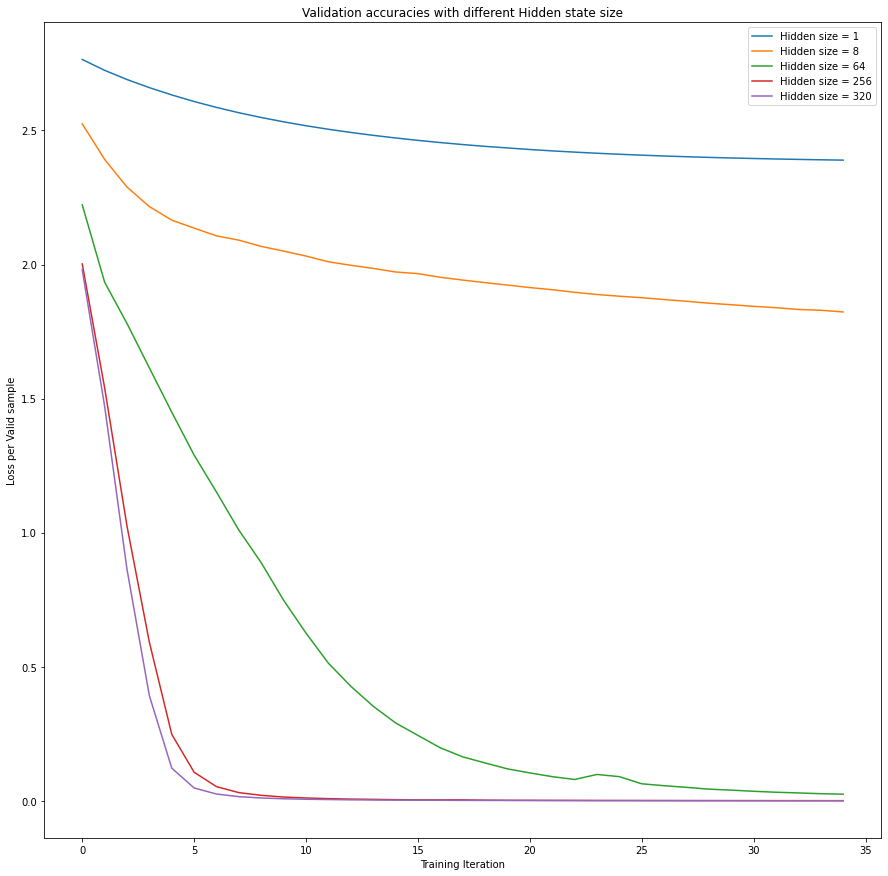

In [15]:
# Hyperparameters
plt.figure(figsize=(15,15))
encoder_embedding_size = 256
hidden_sizes = [1,8,64,256, 320]
num_layers = 1
learning_rate = 0.001
num_epochs = 35


#Encoder/decoder parameters that don't change
input_size_encoder = dataset.n_words
encoder_dropout = 0.5
input_size_decoder = len(idx_2_word)
decoder_dropout = 0.5
output_size = len(idx_2_word)


#Make a loss function that ignores padding
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#Iterate through each candidate hidden size
for h in hidden_sizes:
  title = "Hidden size = " + str(h)
  print(title)

  #Make a new model with that hidden size
  test_encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                            h, num_layers, encoder_dropout).to(device)


  
  test_decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                            h, num_layers, decoder_dropout, output_size).to(device)

  test_model = Seq2Seq(test_encoder_lstm, test_decoder_lstm).to(device)
  #Make an optimizer for that model
  optimizer = optim.Adam(test_model.parameters(), lr=learning_rate)
  #Train and plot
  t_loss, v_loss = train(test_model, learning_rate, optimizer, criterion, verbose = False, loss_out = True)
  plt.plot(v_loss, label = title)

plt.title("Validation accuracies with different Hidden state size")
plt.legend()
plt.xlabel("Training Iteration")
plt.ylabel("Loss per Valid sample")
plt.show()


I found that small values for the hidden layer size had difficulty converging to a suitable accuracy(ie sizes like 1,8). Larger hidden layer sizes reached lower losses, but the train time was much longer. Once the hidden layer size got sufficiently large, the final loss wasn't changed much by increasing the hidden_size, but train time continued to rise.

 Overall, I decided that a hidden layer size of 256 was good since this reached a very low minimum loss in a short amount of epochs. Also, increasing the layer size further had no noticable effect in terms of loss but increased time to convergence.

Num Layers = 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Total train time: 97.60735702514648 seconds
Num Layers = 2
Total train time: 177.9113392829895 seconds
Num Layers = 3
Total train time: 267.94097352027893 seconds


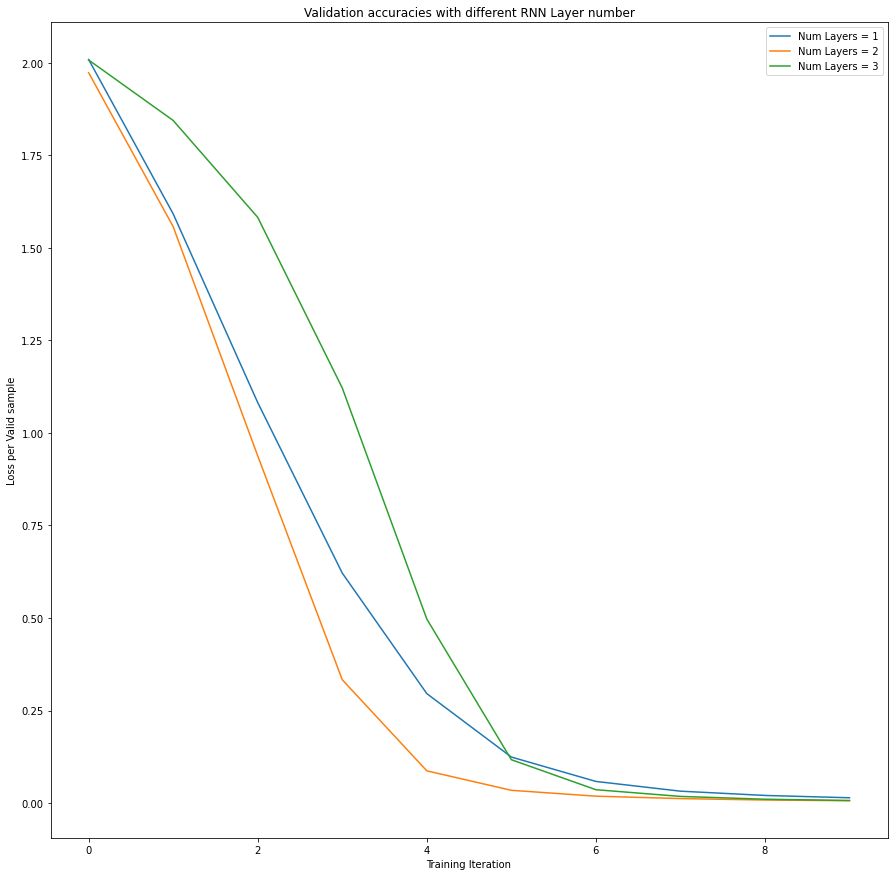

In [16]:
# Hyperparameters
plt.figure(figsize=(15,15))
encoder_embedding_size = 256
hidden_size = 256
RNN_layers = [1,2,3]
learning_rate = 0.001
num_epochs = 10

#Unchanging encoder/decoder params
input_size_encoder = dataset.n_words
encoder_dropout = 0.5
input_size_decoder = len(idx_2_word)
decoder_dropout = 0.5
output_size = len(idx_2_word)

#Make a loss function
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)




for r in RNN_layers:
  title = "Num Layers = " + str(r)
  print(title)

  #Make a new model for the new number of layers
  t_encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                            hidden_size, r, encoder_dropout).to(device)



  t_decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                            hidden_size, r, decoder_dropout, output_size).to(device)

  t_model = Seq2Seq(t_encoder_lstm, t_decoder_lstm).to(device)

  #Make an optimizer for that model
  optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

  #Run training and plot
  t_loss, v_loss = train(t_model, learning_rate, optimizer, criterion, verbose = False, loss_out = True)
  plt.plot(v_loss, label = title)

plt.title("Validation accuracies with different RNN Layer number")
plt.legend()
plt.xlabel("Training Iteration")
plt.ylabel("Loss per Valid sample")
plt.show()


For layer number, I found that increasing the number of layers increased runtime exponentially. I had originally planned to run the experiment for layer numbers 4 and 5 but the training was overly slow(>10 minutes).

For the experiment I did run, the number of layers didn't have a huge effect on loss. However, 2 layers did perform the best(converged in the least epochs), so I selected that for my model. 

## Train the final model using experimental findings
I am using parameters determined by my experiment: hidden layer size of 256 and 2 layers.

Epoch number: 0/20
Train_Loss - 2.0162944288577065
Val_Loss - 2.553455913066864
Time - 17.80151653289795 seconds

Epoch number: 1/20
Train_Loss - 1.6418809648287498
Val_Loss - 1.859608542919159
Time - 17.926746606826782 seconds

Epoch number: 2/20
Train_Loss - 1.027828112497168
Val_Loss - 1.3725902318954468
Time - 17.936467170715332 seconds

Epoch number: 3/20
Train_Loss - 0.40460301733623116
Val_Loss - 0.6904656529426575
Time - 17.89376163482666 seconds

Epoch number: 4/20
Train_Loss - 0.1034185370525061
Val_Loss - 0.1799804225564003
Time - 18.00609016418457 seconds

Epoch number: 5/20
Train_Loss - 0.03650550547418958
Val_Loss - 0.053110895305871965
Time - 17.83906841278076 seconds

Epoch number: 6/20
Train_Loss - 0.01902540266450684
Val_Loss - 0.025109979230910538
Time - 17.885820150375366 seconds

Epoch number: 7/20
Train_Loss - 0.011853948267082037
Val_Loss - 0.01550870891660452
Time - 17.859060287475586 seconds

Epoch number: 8/20
Train_Loss - 0.008547900426122596
Val_Loss - 0.009

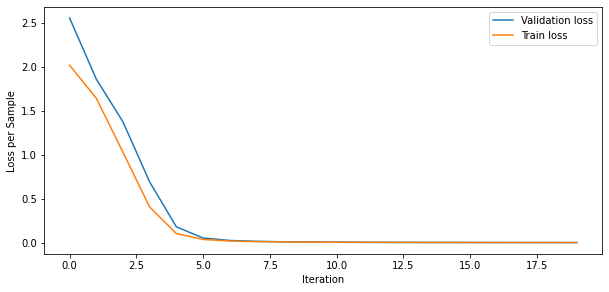

Total train time: 355.12435960769653 seconds


In [17]:
# Hyperparameters
encoder_embedding_size = 256
hidden_size = 256
num_layers = 2
num_epochs = 20
learning_rate = 0.001

#Encoder/decoder parameters
input_size_encoder = dataset.n_words
encoder_dropout = 0.5
input_size_decoder = len(idx_2_word)
decoder_dropout = 0.5
output_size = len(idx_2_word)


#Create an encoder
encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)


#Create a decoder
decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)

#Make a seq2seq model
model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Ignore any padded index numbers
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#Call the train function
train(model, learning_rate, optimizer, criterion)

#Section 3: Analysis and reflection

I declared some helper functions to help with model inference. outputParse takes in the model output and/or target values and removes EOS/SOS/PAD to make it easily human readable

In [18]:
#Helper function for inference
def outputParse(outputs):
  #Reformat the model outputs
  outputs = np.array(outputs).T
  translated_sentences = []
  #Translate it with the dictionary from part 1
  for sentence in outputs:
    temp = []
    for x in range(sentence.shape[0]):
      #Stop any sequences at EOS
      if idx_2_word[sentence[x]] == '<eos>':
        break
      temp.append(idx_2_word[sentence[x]])

    translated_sentences.append(temp)
  translate_sentence = 1
  return translated_sentences

Translate_sentence runs inference. This is very similar to the forward pass of the Seq2Seq model except teacher forcing is never used. The prediction of the decoder at the previous timestep is always used as input for the next timestep without any knowledge of the target. The decoder is only primed with an SOS token

In [19]:
def translate_sentence(model, batch, device, max_length=50):
    outputs = []
    sentence = batch[0].to(device)

    #Run inference on a batch
    with torch.no_grad():
    #Get cell states
        hidden, cell = model.Encoder_LSTM(sentence)

    x = sentence[0] # Trigger token <SOS>

    #Iterate for a maximum of 50 iterations
    for _ in range(max_length):
        previous_word = x

        with torch.no_grad():

            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)

            best_guess = output.argmax(1)
        #Feed its guess into itself for the next element of the sequence
        x = best_guess
        outputs.append(best_guess.detach().tolist())

    #Parse the output
    translated_sentences = outputParse(outputs)
    actual = outputParse(batch[1][1:].tolist())
    
    return translated_sentences, actual


Run inference of the model on the entire test set

In [27]:
model.eval()
correct = 0
incorrect = 0
badpreds = []
count = 0

#Run trhough the test dataloader
for batch in test_DL:
  model.eval()
  #Run inference
  preds, targets = translate_sentence(model, batch , device)

  #Print out some example predictions and targets
  if count == 0:
    print("Example predictions and corresponding targets:")
    for x in range(1,4):
      print("Prediction: "+ str(x))
      print(preds[x])
      print("Target: " + str(x))
      print(targets[x])
      print()

  count = count + 1
  #Calculate accuracy
  for x in range(len(preds)):
    if preds[x] == targets[x]:
      correct +=1
    else:
      incorrect +=1
      badpreds.append([preds[x],targets[x]])
print("Accuracy on the test set is: " + str(100*correct/(correct+incorrect)) + "%")

Example predictions and corresponding targets:
Prediction: 1
['4', '8', '5', '4', '2']
Target: 1
['4', '8', '5', '4', '2']

Prediction: 2
['5', '8', '0', '0', '9']
Target: 2
['5', '8', '0', '0', '9']

Prediction: 3
['8', '9', '1', '1', '3']
Target: 3
['8', '9', '1', '1', '3']

Accuracy on the test set is: 99.99%


Print out the predictions where things went wrong to identify patterns

In [22]:
#Examine cases where predictions went wrong
badpreds

[[['4'], ['0']], [['1'], ['1', '0']]]

### Performance analysis

**What does the model do well:** The model does an extraordinary job overall at translating the word representation to a numerical representation. Every time I ran training, it achieved an accuracy above 99% on the test set.

**What are failure modes/where does the model fail:** When predictions are incorrect, they tend to come from input sequences with zeros. Intuitively this makes a little bit of sense: zeros can be implied by a large variety of letter sequences. For example (100, 1000, 90) all have different characters that indicate a zero, but all 9's are indicated by something containing 'nin'. The sequences where it failed also tended to be short. This could be the case because the encoder more often encodes for longer sequences, so it creates a state that easily adapts to long sequences. For example, in the dataset there is only 1 one digit number starting with '4' but there are 1000 4 digit numbers starting with '4'.

**How could I improve the system:** As it stands, the system doesn't particularly need improvement. It would be interesting to test it on a larger or more varied dataset to identify issues. Some ideas for things to try if the system were inadequate for a problem would be: introducing attention to the decoder, changing the embedding dimension, or altering the dropout in the encoder/decoder. The most interesting of these options is attention. Attention allows the model to weight encoder outputs from many timesteps in the past. This makes it so that there is more than one weighted context vector carrying the burden of characterizing the input. This type of model can more easily draw connections over long time frames. For this simple use-case, it did not seem necessary.

### Attribution 
Once again, here are the sources from my research

Sources:

1) 
https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf

2) 
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

3) 
https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

I mostly used the third source. It served as my starter code for the seq2seq model.

### Reflection

**What were the biggest challenges of this assignment**: The biggest challenge was debugging dimensionality issues in the LSTM seq2seq model. 

**What were mistakes I made:** A few times, I caught myself trying to do too much before checking that what I had worked as expected. For example, when working through the model implementation, I started with the entire model from my 3rd source and was originally debugging error messages as they came up for my new dataset. I found that it was much more straightforward to start by printing out dimensionalities at each stage of the model's forward function(s). This made it clearer what went wrong than the (often cryptic) error messages

**What would I have done differently:** I would have more thoroughly read the sources before starting my implementation. On my first pass through, I thought that I understood everything, so I moved onto the implementation section. But, I noticed that I missed some subtleties(such as how to correctly make SOS/EOS symbols) and it ultimately took more time to fix it during the implementation stage

**What lessons did I learn:** The main thing I learned from a technical standpoint was about the seq2seq approach! We talked over it briefly in class, but this assignment solidified my understanding of how multiple LSTMs can interact in a more complex system. From a programmer's standpoint, this assignment reaffirmed the importance of keeping track of dimensionalities and thoughtfully designing the system before starting to code.